# DwC Events. PSZMP data

**Puget Sound Zooplankton Monitoring Program dataset.** Alignment of dataset to Darwin Core (DwC) for NANOOS, https://www.nanoos.org. This data alignment work, including this Jupyter notebook, are described in the GitHub repository https://github.com/nanoos-pnw/obis-pszmp. See [README.md](https://github.com/nanoos-pnw/obis-pszmp/blob/main/README.md).   

Emilio Mayorga, https://github.com/emiliom   

2/12,10-9, 1/31/2024

## Goals and scope of this notebook

Parse the source data to define and pull out 3 event "types": `cruise`, `stationVisit` and `sample`. The DwC event table is populated sequentially for each of those event types, in that order, from the most temporally aggregated (cruise) to the most granular (sample). Columns are populated differently depending on the event type. The notebook generates the DwC "event" file `DwC_event.csv`.

## Settings

In [1]:
from datetime import datetime
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

from data_preprocess import read_and_parse_sourcedata

In [2]:
data_pth = Path(".")

Set to `True` when debugging. `csv` ﬁles will not be exported when `debug_no_csvexport = True`

In [3]:
debug_no_csvexport = False

## Process JSON file containing common mappings and strings

In [4]:
with open(data_pth / 'common_mappings.json') as f:
    common_mappings = json.load(f)

In [5]:
DatasetCode = common_mappings['datasetcode']
cruises = common_mappings['cruises']
stations = common_mappings['stations']
net_tow = common_mappings['net_tow']

iso8601_format = common_mappings['iso8601_format']
CRS = common_mappings['CRS']

## Pre-process data from Excel file for Event table

### Read and pre-processe the source data from Excel file

`usecols` defines the columns that will be kept and the order in which they'll be organized

In [6]:
# From the Hood Canal dataset
# usecols = [
#     'sample_code', 'mesh_size', 'FWC_DS', 
#     'station', 'latitude', 'longitude', 
#     'date', 'time_start', 'time', 'day_night', 
#     'depth_min', 'depth_max',
#     'net_code', 'extra_sample_token'
# ]

# Note: I'm including 'Sample Date' and 'Sample Time' just for QA/QC, if needed.
# They won't be used here, since 'time' already captures that information
usecols = [
    'Sample Code', 
    'Station', 'Latitude', 'Longitude', 'Site Name', 'Basin', 'Sampling Group',
    'Sample Date', 'Sample Time', 'Day_Night', 'time',
    'Min Tow Depth (m)', 'Max Tow Depth (m)', 'Station Depth (m)',
    'Mesh Size', 'Tow Type', 
]

# eventsource_df = read_and_parse_sourcedata(test_n_rows=1000)[usecols]
eventsource_df = read_and_parse_sourcedata()[usecols]

# TODO: Rename more columns, if needed
eventsource_df.rename(
    columns={
        'Sample Code':'sample_code',
        'Station':'station',
        'Latitude':'latitude',
        'Longitude':'longitude',
        'Min Tow Depth (m)':'depth_min', 
        'Max Tow Depth (m)':'depth_max', 
        'Mesh Size': 'mesh_size',
    },
    inplace=True
)

In [7]:
len(eventsource_df)

153825

**KEEP A COPY OF THE DATAFRAME WHILE STILL IRONING OUT THIS NOTEBOOK. FOR CONVENIENCE**

In [8]:
eventsource_df_UNMODIFIED = eventsource_df.copy()

In [9]:
# eventsource_df = eventsource_df_UNMODIFIED.copy()

In [10]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical
1,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical
2,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical
3,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical
4,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical


### Remove duplicates

Will return only unique samples, where one row = one sample.

In [11]:
eventsource_df = eventsource_df.drop_duplicates().sort_values(by='sample_code').reset_index(drop=True)

In [12]:
len(eventsource_df)

3567

### `sample_code` examination

 Sample codes are 14-17 characters long, except for 4 entries that are 12 & 13 characters long.

In [13]:
eventsource_df['sample_code'].str.len().value_counts()

14    1384
17     922
15     860
16     397
12       2
13       2
Name: sample_code, dtype: int64

## Create empty Event dataframe

Records from each event type will be appended to this dataframe, by "type". The type is encoded in the `eventType` column, not in the DwC `type` column, which is not used here explicitly (the type is `Event`).

In [14]:
event_cols_dtypes = np.dtype(
    [
        ('eventID', str),
        ('eventType', str), 
        ('parentEventID', str),
        ('eventDate', str), 
        ('locationID', str),
        ('locality', str),
        ('decimalLatitude', float),
        ('decimalLongitude', float),
        ('footprintWKT', str),
        ('geodeticDatum', str),
        ('waterBody', str),
        ('countryCode', str), 
        ('minimumDepthInMeters', float),
        ('maximumDepthInMeters', float),
        ('samplingProtocol', str)
    ]
)

In [15]:
event_df = pd.DataFrame(np.empty(0, dtype=event_cols_dtypes))

## Create cruise events

Use 'Sampling Group' as the grouping attribute, analogous to cruises. Set up a dictionary in `common_mappings.json` matching up the 'Sampling Group' strings to fleshed out descriptions and anything else that might be relevant.

- Assign cruise code based on a date string and a sanitized version of `Sampling Group` strings, from `cruises`
- Use `group_by` to generate cruise `time` start and end
- Come up with cruise `eventID`. Come up with a project/dataset code first
- Populating `event_df` with cruise events

Add cruise-related columns to `eventsource_df`. `date_yyyymmdd` will be used to link cruise events to stationVisit events

In [16]:
eventsource_df['date_yyyymmdd'] = eventsource_df['time'].apply(lambda dt: dt.strftime("%Y%m%d"))
eventsource_df['cruise_code'] = (
    eventsource_df['date_yyyymmdd'] + "_" + eventsource_df['Sampling Group'].apply(lambda s: cruises[s])
)

In [17]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-07:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-07:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-07:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-07:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC


### Create cruise footprintWKT and centroid points

**TODO:** Some cruise code entries will contain a single point, so it won't be possible to generate a polygon for `footprintWKT`. Will skip for now. Later, will also figure out how to calculate `decimalLongitude` and `decimalLatitude`, since they can't be universally generated from polygons.

In [18]:
cruise_stations_df = eventsource_df[['cruise_code', 'latitude', 'longitude', 'Basin', 'Sampling Group']].drop_duplicates()

In [19]:
cruise_stations_gdf = gpd.GeoDataFrame(
    data=cruise_stations_df,
    geometry=gpd.points_from_xy(cruise_stations_df.longitude, cruise_stations_df.latitude, crs=CRS)
)

len(cruise_stations_gdf)

3007

In [20]:
cruise_stations_gdf.head()

,cruise_code,latitude,longitude,Basin,Sampling Group,geometry
0,20180102_LUM,48.63795,-122.5694,Bellingham Bay,LUM,POINT (-122.56940 48.63795)
1,20220103_KC,47.74396,-122.4282,Central Basin,KC,POINT (-122.42820 47.74396)
2,20220104_KC,47.53333,-122.4333,Central Basin,KC,POINT (-122.43330 47.53333)
4,20220104_KC,47.35862,-122.3871,Central Basin,KC,POINT (-122.38710 47.35862)
5,20210106_NOAA,48.25673,-122.5442,Whidbey Basin,NOAA,POINT (-122.54420 48.25673)


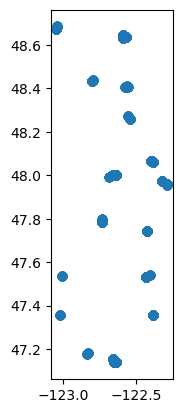

In [21]:
cruise_stations_gdf.plot();

Create one convex hull polygon for each cruise

**TODO:** Remove `footprintWKT` entry if its geo type is LINESTRING OR POINT?

In [22]:
cruise_footprints_gdf = gpd.GeoDataFrame(
    cruise_stations_gdf.groupby(['cruise_code'])['geometry'].apply(
        lambda geom: geom.unary_union.convex_hull)
)
cruise_footprints_gdf['footprintWKT'] = cruise_footprints_gdf.geometry.to_wkt()
# Add footprint centroid latitude and longitude
cruise_footprints_gdf['decimalLongitude'] = cruise_footprints_gdf.centroid.x.round(3)
cruise_footprints_gdf['decimalLatitude'] = cruise_footprints_gdf.centroid.y.round(3)
cruise_footprints_gdf.reset_index(drop=False, inplace=True)

In [23]:
cruise_footprints_gdf

,cruise_code,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,20140325_NIT,"POLYGON ((-122.83550 47.17593, -122.83520 47.1...","POLYGON ((-122.8355 47.17593, -122.8352 47.176...",-122.833,47.180
1,20140401_NIT,"POLYGON ((-122.63540 47.13843, -122.63670 47.1...","POLYGON ((-122.6354 47.13843, -122.6367 47.138...",-122.644,47.144
2,20140404_PGST_WDFW,POINT (-122.63600 48.00273),POINT (-122.636 48.00273),-122.636,48.003
3,20140409_KC,"POLYGON ((-122.38710 47.35862, -122.43330 47.5...","POLYGON ((-122.3871 47.35862, -122.4333 47.533...",-122.416,47.545
4,20140409_NIT,"POLYGON ((-122.63540 47.13843, -122.83550 47.1...","POLYGON ((-122.6354 47.13843, -122.8355 47.175...",-122.737,47.162
...,...,...,...,...,...
1328,20221212_KWT,"LINESTRING (-123.04810 48.67437, -122.80370 48...","LINESTRING (-123.0481 48.67437, -122.8037 48.4...",-122.926,48.554
1329,20221212_TUL,"LINESTRING (-122.38730 48.05901, -122.32220 47...","LINESTRING (-122.3873 48.05901, -122.3222 47.9...",-122.355,48.015
1330,20221214_HCSEG_DOE,"LINESTRING (-123.02490 47.35620, -123.00960 47...","LINESTRING (-123.0249 47.3562, -123.0096 47.53...",-123.017,47.447
1331,20221215_NOAA_STIL,POINT (-122.54420 48.25673),POINT (-122.5442 48.25673),-122.544,48.257


In [24]:
# cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymmdd', 'Basin']).agg({
cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymmdd', 'Sampling Group']).agg({
    'time':['min', 'max'],
    'depth_min':['min'],
    'depth_max':['max'],
    'Basin':['first']
})
cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]
cruise_df = (
    cruise_df.
    rename(columns={
        'depth_min_min':'minimumDepthInMeters', 
        'depth_max_max':'maximumDepthInMeters',
        'Basin_first': 'Basin',
        })
    .sort_values(by='cruise_code')
    .reset_index(drop=False)
)
cruise_df

/tmp/ipykernel_2058829/359004418.py:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]


,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,Basin
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,40.0,South Sound
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,122.0,South Sound
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,100.0,Admiralty Inlet
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,200.0,Central Basin
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,123.0,South Sound
...,...,...,...,...,...,...,...,...
1328,20221212_KWT,20221212,KWT,2022-12-12 11:27:00-07:00,2022-12-12 13:44:00-07:00,0.0,30.0,San Juan
1329,20221212_TUL,20221212,TUL,2022-12-12 11:42:00-07:00,2022-12-12 12:31:00-07:00,0.0,200.0,Whidbey Basin
1330,20221214_HCSEG_DOE,20221214,HCSEG/DOE,2022-12-14 10:29:00-07:00,2022-12-14 11:37:00-07:00,0.0,139.0,Hood Canal
1331,20221215_NOAA_STIL,20221215,NOAA/STIL,2022-12-15 11:37:00-07:00,2022-12-15 11:37:00-07:00,0.0,85.0,Whidbey Basin


**TODO:** In `cruise_df`, `cruise_code` values are not unique! I see what's going on: some "cruises" involve visits to sites in different Basins (eg, '20221219_PGST_WDFW', '20150804_PGST_WDFW'). See the example below. So, I can't include `Basin` in the creation of `cruise_df`, above. But then I won't be able to enter a useful, granular value into `waterBody`! *For now, I'm using the FIRST occurrence of `Basin` to populate `waterBody`.* It won't be strictly accurate for cruises with >1 `Basin`, but that's only ~ 60 cruises -- a very small percent of the total.

In [25]:
len(cruise_df), len(cruise_df.cruise_code.unique()), len(cruise_footprints_gdf)

(1333, 1333, 1333)

In [26]:
# This form is for populating eventDate with an iso8601 interval
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),

cruise_df['eventDate'] = cruise_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [27]:
cruise_df = cruise_df.merge(cruise_footprints_gdf, on='cruise_code')
len(cruise_df)

1333

In [28]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,Basin,eventDate,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,40.0,South Sound,2014-03-25T10:35:00-0700,"POLYGON ((-122.83550 47.17593, -122.83520 47.1...","POLYGON ((-122.8355 47.17593, -122.8352 47.176...",-122.833,47.180
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,122.0,South Sound,2014-04-01T10:01:00-0700,"POLYGON ((-122.63540 47.13843, -122.63670 47.1...","POLYGON ((-122.6354 47.13843, -122.6367 47.138...",-122.644,47.144
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,100.0,Admiralty Inlet,2014-04-04T13:00:00-0700,POINT (-122.63600 48.00273),POINT (-122.636 48.00273),-122.636,48.003
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,200.0,Central Basin,2014-04-09T09:25:00-0700,"POLYGON ((-122.38710 47.35862, -122.43330 47.5...","POLYGON ((-122.3871 47.35862, -122.4333 47.533...",-122.416,47.545
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,123.0,South Sound,2014-04-09T10:30:00-0700,"POLYGON ((-122.63540 47.13843, -122.83550 47.1...","POLYGON ((-122.6354 47.13843, -122.8355 47.175...",-122.737,47.162


In [29]:
cruise_df['eventID'] = DatasetCode + "_" + cruise_df['cruise_code']
cruise_df['eventType'] = 'cruise'  # Should it be something different? Sampling a single station hardly qualifies as a cruise
cruise_df['geodeticDatum'] = CRS
cruise_df['waterBody'] = cruise_df['Basin'] + ', Salish Sea'  # Puget Sound somewhere in there?
cruise_df['countryCode'] = 'US'

In [30]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,Basin,eventDate,geometry,footprintWKT,decimalLongitude,decimalLatitude,eventID,eventType,geodeticDatum,waterBody,countryCode
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,40.0,South Sound,2014-03-25T10:35:00-0700,"POLYGON ((-122.83550 47.17593, -122.83520 47.1...","POLYGON ((-122.8355 47.17593, -122.8352 47.176...",-122.833,47.180,PSZMP_20140325_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,122.0,South Sound,2014-04-01T10:01:00-0700,"POLYGON ((-122.63540 47.13843, -122.63670 47.1...","POLYGON ((-122.6354 47.13843, -122.6367 47.138...",-122.644,47.144,PSZMP_20140401_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,100.0,Admiralty Inlet,2014-04-04T13:00:00-0700,POINT (-122.63600 48.00273),POINT (-122.636 48.00273),-122.636,48.003,PSZMP_20140404_PGST_WDFW,cruise,EPSG:4326,"Admiralty Inlet, Salish Sea",US
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,200.0,Central Basin,2014-04-09T09:25:00-0700,"POLYGON ((-122.38710 47.35862, -122.43330 47.5...","POLYGON ((-122.3871 47.35862, -122.4333 47.533...",-122.416,47.545,PSZMP_20140409_KC,cruise,EPSG:4326,"Central Basin, Salish Sea",US
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,123.0,South Sound,2014-04-09T10:30:00-0700,"POLYGON ((-122.63540 47.13843, -122.83550 47.1...","POLYGON ((-122.6354 47.13843, -122.8355 47.175...",-122.737,47.162,PSZMP_20140409_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US


### Populate (append to) the `event_df` table with the cruise events

In [31]:
event_df = pd.concat(
    [
        event_df,
        cruise_df[[
            'eventID', 'eventType', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'footprintWKT', 'geodeticDatum', 
            'waterBody', 'countryCode', 'minimumDepthInMeters', 'maximumDepthInMeters'
        ]]
    ],
    ignore_index=True
)

In [32]:
event_df.head()

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
0,PSZMP_20140325_NIT,cruise,NaN,2014-03-25T10:35:00-0700,NaN,NaN,47.180,-122.833,"POLYGON ((-122.8355 47.17593, -122.8352 47.176...",EPSG:4326,"South Sound, Salish Sea",US,0.0,40.0,NaN
1,PSZMP_20140401_NIT,cruise,NaN,2014-04-01T10:01:00-0700,NaN,NaN,47.144,-122.644,"POLYGON ((-122.6354 47.13843, -122.6367 47.138...",EPSG:4326,"South Sound, Salish Sea",US,0.0,122.0,NaN
2,PSZMP_20140404_PGST_WDFW,cruise,NaN,2014-04-04T13:00:00-0700,NaN,NaN,48.003,-122.636,POINT (-122.636 48.00273),EPSG:4326,"Admiralty Inlet, Salish Sea",US,0.0,100.0,NaN
3,PSZMP_20140409_KC,cruise,NaN,2014-04-09T09:25:00-0700,NaN,NaN,47.545,-122.416,"POLYGON ((-122.3871 47.35862, -122.4333 47.533...",EPSG:4326,"Central Basin, Salish Sea",US,0.0,200.0,NaN
4,PSZMP_20140409_NIT,cruise,NaN,2014-04-09T10:30:00-0700,NaN,NaN,47.162,-122.737,"POLYGON ((-122.6354 47.13843, -122.8355 47.175...",EPSG:4326,"South Sound, Salish Sea",US,0.0,123.0,NaN


## Create stationVisit events

- Use cruise `eventID` from `eventsource_df` as stationVisit `parentEventID`
- Add `stationvisit_code` to `eventsource_df`, for use by the next event type (sample)

In [33]:
pd.DataFrame(eventsource_df[eventsource_df['station'] == 'KSBP01D']['sample_code'].value_counts()).head(10)

,sample_code
010322KSBP01D0815,1
090721KSBP01D0919,1
082817KSBP01D1020,1
090319KSBP01D0918,1
090418KSBP01D1338,1
090517KSBP01D0930,1
090616KSBP01D0824,1
090622KSBP01D0939,1
090820KSBP01D0922,1
100118KSBP01D0908,1


In [34]:
# eventsource_df['Sample Code'].str[0:-4].head(10)

`stationvisit_code` will be composed of the date (`date_yyyymmdd`), `Day_Night` and `station`.

In [35]:
eventsource_df['stationvisit_code'] = (
    # eventsource_df['sample_code'].str[0:-4] + eventsource_df['Day_Night']
    eventsource_df['date_yyyymmdd'] + eventsource_df['Day_Night'] + "_" + eventsource_df['station']
)

In [36]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-07:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-07:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-07:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-07:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [37]:
stationvisit_df = eventsource_df.groupby(
    ['station', 'latitude', 'longitude', 'date_yyyymmdd', 'Day_Night', 'stationvisit_code', 'Basin', 'Site Name', 'Sampling Group']
).agg({
    'time':['min', 'max'],
    'depth_min':['min'],
    'depth_max':['max'],
})
stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]
stationvisit_df = (
    stationvisit_df
    .sort_values(by='time_min')
    .reset_index(drop=False)
)

len(stationvisit_df)

/tmp/ipykernel_2058829/548955238.py:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]


3567

**TODO:**
- Below, some records have `depth_min_min` > `depth_max_max`! That's non-sensical. It may be due to inconsistent data entry patterns. I may needed to take a different approach: calculate `depth_min_min` as the min and `depth_max_max` as the max of either `depth_min` or `depth_max`
- ~~DONE. For station `waterBody`, use the stationvisit's own `Basin` value rather than the cruise's `waterBody`. That's to sidestep the issue of cruises that span two Basins, for which I'm only retaining one of them for the cruise.~~

In [38]:
stationvisit_df.head(10)

,station,latitude,longitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,time_max,depth_min_min,depth_max_max
0,DANAV,47.18327,-122.8307,20140325,D,20140325D_DANAV,South Sound,Dana Passage,NIT,2014-03-25 10:35:00-07:00,2014-03-25 10:35:00-07:00,0.0,40.0
1,DANAS,47.17593,-122.8355,20140325,D,20140325D_DANAS,South Sound,Dana Passage,NIT,2014-03-25 11:08:00-07:00,2014-03-25 11:08:00-07:00,15.0,0.0
2,DANAM,47.17678,-122.8352,20140325,D,20140325D_DANAM,South Sound,Dana Passage,NIT,2014-03-25 11:26:00-07:00,2014-03-25 11:26:00-07:00,20.0,0.0
3,DANAD,47.17997,-122.8318,20140325,D,20140325D_DANAD,South Sound,Dana Passage,NIT,2014-03-25 11:47:00-07:00,2014-03-25 11:47:00-07:00,30.0,0.0
4,SKETV,47.15243,-122.6586,20140401,D,20140401D_SKETV,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:01:00-07:00,2014-04-01 10:01:00-07:00,0.0,122.0
5,SKETS,47.13843,-122.6354,20140401,D,20140401D_SKETS,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:55:00-07:00,2014-04-01 10:55:00-07:00,10.0,0.0
6,SKETM,47.13892,-122.6367,20140401,D,20140401D_SKETM,South Sound,South Ketron/Solo Point,NIT,2014-04-01 11:20:00-07:00,2014-04-01 11:20:00-07:00,20.0,0.0
7,SKETD,47.14032,-122.6377,20140401,D,20140401D_SKETD,South Sound,South Ketron/Solo Point,NIT,2014-04-01 11:50:00-07:00,2014-04-01 11:50:00-07:00,30.0,0.0
8,ADIV,48.00273,-122.6360,20140404,D,20140404D_ADIV,Admiralty Inlet,Admiralty Inlet,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,100.0
9,KSBP01V,47.74396,-122.4282,20140409,D,20140409D_KSBP01V,Central Basin,Point Jefferson,KC,2014-04-09 09:25:00-07:00,2014-04-09 09:25:00-07:00,0.0,200.0


In [39]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,minimumDepthInMeters,maximumDepthInMeters,Basin,eventDate,geometry,footprintWKT,decimalLongitude,decimalLatitude,eventID,eventType,geodeticDatum,waterBody,countryCode
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,40.0,South Sound,2014-03-25T10:35:00-0700,"POLYGON ((-122.83550 47.17593, -122.83520 47.1...","POLYGON ((-122.8355 47.17593, -122.8352 47.176...",-122.833,47.180,PSZMP_20140325_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,122.0,South Sound,2014-04-01T10:01:00-0700,"POLYGON ((-122.63540 47.13843, -122.63670 47.1...","POLYGON ((-122.6354 47.13843, -122.6367 47.138...",-122.644,47.144,PSZMP_20140401_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,100.0,Admiralty Inlet,2014-04-04T13:00:00-0700,POINT (-122.63600 48.00273),POINT (-122.636 48.00273),-122.636,48.003,PSZMP_20140404_PGST_WDFW,cruise,EPSG:4326,"Admiralty Inlet, Salish Sea",US
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,200.0,Central Basin,2014-04-09T09:25:00-0700,"POLYGON ((-122.38710 47.35862, -122.43330 47.5...","POLYGON ((-122.3871 47.35862, -122.4333 47.533...",-122.416,47.545,PSZMP_20140409_KC,cruise,EPSG:4326,"Central Basin, Salish Sea",US
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,123.0,South Sound,2014-04-09T10:30:00-0700,"POLYGON ((-122.63540 47.13843, -122.83550 47.1...","POLYGON ((-122.6354 47.13843, -122.8355 47.175...",-122.737,47.162,PSZMP_20140409_NIT,cruise,EPSG:4326,"South Sound, Salish Sea",US


In [40]:
stationvisit_df = stationvisit_df.merge(
    # cruise_df[['date_yyyymmdd', 'eventID', 'waterBody', 'countryCode']],
    cruise_df[['date_yyyymmdd', 'Sampling Group', 'eventID', 'countryCode']],
    how='left', 
    on=['date_yyyymmdd', 'Sampling Group']
)

stationvisit_df['waterBody'] = stationvisit_df['Basin'] + ', Salish Sea'

In [41]:
len(stationvisit_df)

3567

In [42]:
stationvisit_df.head()

,station,latitude,longitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,time_max,depth_min_min,depth_max_max,eventID,countryCode,waterBody
0,DANAV,47.18327,-122.8307,20140325,D,20140325D_DANAV,South Sound,Dana Passage,NIT,2014-03-25 10:35:00-07:00,2014-03-25 10:35:00-07:00,0.0,40.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea"
1,DANAS,47.17593,-122.8355,20140325,D,20140325D_DANAS,South Sound,Dana Passage,NIT,2014-03-25 11:08:00-07:00,2014-03-25 11:08:00-07:00,15.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea"
2,DANAM,47.17678,-122.8352,20140325,D,20140325D_DANAM,South Sound,Dana Passage,NIT,2014-03-25 11:26:00-07:00,2014-03-25 11:26:00-07:00,20.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea"
3,DANAD,47.17997,-122.8318,20140325,D,20140325D_DANAD,South Sound,Dana Passage,NIT,2014-03-25 11:47:00-07:00,2014-03-25 11:47:00-07:00,30.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea"
4,SKETV,47.15243,-122.6586,20140401,D,20140401D_SKETV,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:01:00-07:00,2014-04-01 10:01:00-07:00,0.0,122.0,PSZMP_20140401_NIT,US,"South Sound, Salish Sea"


In [43]:
stationvisit_df.rename(
    columns={
        'station':'locationID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'eventID':'parentEventID',
        'depth_min_min':'minimumDepthInMeters', 
        'depth_max_max':'maximumDepthInMeters',
    },
    inplace=True
)

In [44]:
# This form is for populating eventDate with an iso8601 interval
# stationvisit_df['eventDate'] = stationvisit_df[['time_min', 'time_max']].apply(
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),
#     axis=1
# )

stationvisit_df['eventDate'] = stationvisit_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [45]:
stationvisit_df['eventID'] = DatasetCode + "_" + stationvisit_df['stationvisit_code']
# Using this scheme makes for stationvisit eventID strings that are way too long
# stationvisit_df['eventID'] = stationvisit_df['parentEventID'] + '-' + stationvisit_df['stationvisit_code']
stationvisit_df['eventType'] = 'stationVisit'
# stationvisit_df['locality'] = stationvisit_df['locationID'].apply(lambda cd: stations[cd])
stationvisit_df['locality'] = stationvisit_df['Site Name']
stationvisit_df['geodeticDatum'] = CRS

Verify that no duplicate station `eventID` values are created. The `==` statement below should be `True`

In [46]:
len(stationvisit_df.eventID.unique()) == len(stationvisit_df), len(stationvisit_df)

(True, 3567)

In [47]:
stationvisit_df.head(5)

,locationID,decimalLatitude,decimalLongitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,...,minimumDepthInMeters,maximumDepthInMeters,parentEventID,countryCode,waterBody,eventDate,eventID,eventType,locality,geodeticDatum
0,DANAV,47.18327,-122.8307,20140325,D,20140325D_DANAV,South Sound,Dana Passage,NIT,2014-03-25 10:35:00-07:00,...,0.0,40.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea",2014-03-25T10:35:00-0700,PSZMP_20140325D_DANAV,stationVisit,Dana Passage,EPSG:4326
1,DANAS,47.17593,-122.8355,20140325,D,20140325D_DANAS,South Sound,Dana Passage,NIT,2014-03-25 11:08:00-07:00,...,15.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea",2014-03-25T11:08:00-0700,PSZMP_20140325D_DANAS,stationVisit,Dana Passage,EPSG:4326
2,DANAM,47.17678,-122.8352,20140325,D,20140325D_DANAM,South Sound,Dana Passage,NIT,2014-03-25 11:26:00-07:00,...,20.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea",2014-03-25T11:26:00-0700,PSZMP_20140325D_DANAM,stationVisit,Dana Passage,EPSG:4326
3,DANAD,47.17997,-122.8318,20140325,D,20140325D_DANAD,South Sound,Dana Passage,NIT,2014-03-25 11:47:00-07:00,...,30.0,0.0,PSZMP_20140325_NIT,US,"South Sound, Salish Sea",2014-03-25T11:47:00-0700,PSZMP_20140325D_DANAD,stationVisit,Dana Passage,EPSG:4326
4,SKETV,47.15243,-122.6586,20140401,D,20140401D_SKETV,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:01:00-07:00,...,0.0,122.0,PSZMP_20140401_NIT,US,"South Sound, Salish Sea",2014-04-01T10:01:00-0700,PSZMP_20140401D_SKETV,stationVisit,South Ketron/Solo Point,EPSG:4326


### Populate (append to) the `event_df` table with the stationVisit events

In [48]:
event_df = pd.concat(
    [
        event_df,
        stationvisit_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'locationID', 'locality', 'waterBody', 'countryCode', 
            'minimumDepthInMeters', 'maximumDepthInMeters'
        ]]
    ],
    ignore_index=True
)

len(event_df)

4900

In [49]:
event_df.head(8)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
0,PSZMP_20140325_NIT,cruise,NaN,2014-03-25T10:35:00-0700,NaN,NaN,47.180,-122.833,"POLYGON ((-122.8355 47.17593, -122.8352 47.176...",EPSG:4326,"South Sound, Salish Sea",US,0.0,40.0,NaN
1,PSZMP_20140401_NIT,cruise,NaN,2014-04-01T10:01:00-0700,NaN,NaN,47.144,-122.644,"POLYGON ((-122.6354 47.13843, -122.6367 47.138...",EPSG:4326,"South Sound, Salish Sea",US,0.0,122.0,NaN
2,PSZMP_20140404_PGST_WDFW,cruise,NaN,2014-04-04T13:00:00-0700,NaN,NaN,48.003,-122.636,POINT (-122.636 48.00273),EPSG:4326,"Admiralty Inlet, Salish Sea",US,0.0,100.0,NaN
3,PSZMP_20140409_KC,cruise,NaN,2014-04-09T09:25:00-0700,NaN,NaN,47.545,-122.416,"POLYGON ((-122.3871 47.35862, -122.4333 47.533...",EPSG:4326,"Central Basin, Salish Sea",US,0.0,200.0,NaN
4,PSZMP_20140409_NIT,cruise,NaN,2014-04-09T10:30:00-0700,NaN,NaN,47.162,-122.737,"POLYGON ((-122.6354 47.13843, -122.8355 47.175...",EPSG:4326,"South Sound, Salish Sea",US,0.0,123.0,NaN
5,PSZMP_20140421_KC,cruise,NaN,2014-04-21T14:20:00-0700,NaN,NaN,47.478,-122.407,"POLYGON ((-122.3871 47.35862, -122.4333 47.533...",EPSG:4326,"Central Basin, Salish Sea",US,0.0,200.0,NaN
6,PSZMP_20140422_KC,cruise,NaN,2014-04-22T14:20:00-0700,NaN,NaN,47.744,-122.428,POINT (-122.4282 47.74396),EPSG:4326,"Central Basin, Salish Sea",US,0.0,200.0,NaN
7,PSZMP_20140422_NIT,cruise,NaN,2014-04-22T10:35:00-0700,NaN,NaN,47.180,-122.833,"POLYGON ((-122.8355 47.17593, -122.8352 47.176...",EPSG:4326,"South Sound, Salish Sea",US,0.0,45.0,NaN


## Create individual "sample" events

Each unique `sample_code` will be an event. `sample_code` will be the eventID, possibly prefixed by the dataset code.

In [50]:
sample_df = eventsource_df.copy()
sample_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-07:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-07:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-07:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-07:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-07:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [51]:
sample_df = sample_df.merge(
    stationvisit_df[['stationvisit_code', 'eventID', 'waterBody', 'countryCode', 
                     'locationID', 'locality', 'geodeticDatum']],
    how='left', 
    on='stationvisit_code'
)

In [52]:
sample_df= (
    sample_df
    .rename(columns={
        'sample_code':'eventID',
        'eventID':'parentEventID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'depth_min':'minimumDepthInMeters',
        'depth_max':'maximumDepthInMeters',
    })
    .sort_values(by='time')
    .reset_index(drop=False)
)

**TODO:** Update `samplingProtocol` to PSZMP information.

In [53]:
def samplingProtocol(row):
    return (
        f"{net_tow[row['Tow Type']]} net tow using X.XX m2 YY MultiNet Multiple Plankton Sampler (CONFIRM!),"
        f" {row['mesh_size']} micron mesh"
    )

sample_df['eventType'] = 'sample'
sample_df['eventDate'] = sample_df['time'].apply(lambda t: t.strftime(iso8601_format))
sample_df['samplingProtocol'] = sample_df.apply(samplingProtocol, axis=1)

In [54]:
sample_df.head()

,index,eventID,station,decimalLatitude,decimalLongitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,...,stationvisit_code,parentEventID,waterBody,countryCode,locationID,locality,geodeticDatum,eventType,eventDate,samplingProtocol
0,523,032514DANAV1035,DANAV,47.18327,-122.8307,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,10:35:00,...,20140325D_DANAV,PSZMP_20140325D_DANAV,"South Sound, Salish Sea",US,DANAV,Dana Passage,EPSG:4326,sample,2014-03-25T10:35:00-0700,full water column net tow using X.XX m2 YY Mul...
1,522,032514DANAS1108,DANAS,47.17593,-122.8355,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:08:00,...,20140325D_DANAS,PSZMP_20140325D_DANAS,"South Sound, Salish Sea",US,DANAS,Dana Passage,EPSG:4326,sample,2014-03-25T11:08:00-0700,depth stratified (oblique) net tow using X.XX ...
2,521,032514DANAM1126,DANAM,47.17678,-122.8352,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:26:00,...,20140325D_DANAM,PSZMP_20140325D_DANAM,"South Sound, Salish Sea",US,DANAM,Dana Passage,EPSG:4326,sample,2014-03-25T11:26:00-0700,depth stratified (oblique) net tow using X.XX ...
3,520,032514DANAD1147,DANAD,47.17997,-122.8318,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:47:00,...,20140325D_DANAD,PSZMP_20140325D_DANAD,"South Sound, Salish Sea",US,DANAD,Dana Passage,EPSG:4326,sample,2014-03-25T11:47:00-0700,depth stratified (oblique) net tow using X.XX ...
4,578,040114sketv1001,SKETV,47.15243,-122.6586,South Ketron/Solo Point,South Sound,NIT,2014-04-01 00:00:00,10:01:00,...,20140401D_SKETV,PSZMP_20140401D_SKETV,"South Sound, Salish Sea",US,SKETV,South Ketron/Solo Point,EPSG:4326,sample,2014-04-01T10:01:00-0700,full water column net tow using X.XX m2 YY Mul...


### Populate (append to) the `event_df` table with the sample events

In [55]:
event_df = pd.concat(
    [
        event_df,
        sample_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 'waterBody', 'countryCode', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'minimumDepthInMeters', 'maximumDepthInMeters', 'samplingProtocol'
        ]]
    ],
    ignore_index=True
)

len(event_df)

8467

In [56]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,footprintWKT,geodeticDatum,waterBody,countryCode,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol
8457,120622NSEX01V1236,sample,PSZMP_20221206U_NSEX01V,2022-12-06T12:36:00-0700,NSEX01V,East Passage,47.35862,-122.3871,NaN,EPSG:4326,"Central Basin, Salish Sea",US,0.0,170.0,full water column net tow using X.XX m2 YY Mul...
8458,121222Cow3V21127,sample,PSZMP_20221212U_COW3V2,2022-12-12T11:27:00-0700,COW3V2,Cowlitz,48.67437,-123.0481,NaN,EPSG:4326,"San Juan, Salish Sea",US,NaN,0.0,full water column net tow using X.XX m2 YY Mul...
8459,121222MUKV1142,sample,PSZMP_20221212U_MUKV,2022-12-12T11:42:00-0700,MUKV,Mukilteo,47.97166,-122.3222,NaN,EPSG:4326,"Whidbey Basin, Salish Sea",US,0.0,200.0,full water column net tow using X.XX m2 YY Mul...
8460,121222CAMV1231,sample,PSZMP_20221212U_CAMV,2022-12-12T12:31:00-0700,CAMV,Camano Head,48.05901,-122.3873,NaN,EPSG:4326,"Whidbey Basin, Salish Sea",US,0.0,175.0,full water column net tow using X.XX m2 YY Mul...
8461,121222Wat1V1344,sample,PSZMP_20221212U_WAT1V,2022-12-12T13:44:00-0700,WAT1V,Watmough Bay,48.43457,-122.8037,NaN,EPSG:4326,"San Juan, Salish Sea",US,0.0,30.0,full water column net tow using X.XX m2 YY Mul...
8462,121422HCB003V1029,sample,PSZMP_20221214U_HCB003V,2022-12-14T10:29:00-0700,HCB003V,Eldon,47.53787,-123.0096,NaN,EPSG:4326,"Hood Canal, Salish Sea",US,0.0,139.0,full water column net tow using X.XX m2 YY Mul...
8463,121422HCB004V1137,sample,PSZMP_20221214U_HCB004V,2022-12-14T11:37:00-0700,HCB004V,Sisters Point,47.35620,-123.0249,NaN,EPSG:4326,"Hood Canal, Salish Sea",US,0.0,48.0,full water column net tow using X.XX m2 YY Mul...
8464,121522SARAV1137,sample,PSZMP_20221215D_SARAV,2022-12-15T11:37:00-0700,SARAV,North Saratoga Passage,48.25673,-122.5442,NaN,EPSG:4326,"Whidbey Basin, Salish Sea",US,0.0,85.0,full water column net tow using X.XX m2 YY Mul...
8465,121922ADIV1027,sample,PSZMP_20221219U_ADIV,2022-12-19T10:27:00-0700,ADIV,Admiralty Inlet,48.00273,-122.6360,NaN,EPSG:4326,"Admiralty Inlet, Salish Sea",US,0.0,0.0,full water column net tow using X.XX m2 YY Mul...
8466,121922TDBV1158,sample,PSZMP_20221219D_TDBV,2022-12-19T11:58:00-0700,TDBV,Thorndyke Bay,47.78297,-122.7330,NaN,EPSG:4326,"Hood Canal, Salish Sea",US,0.0,115.0,full water column net tow using X.XX m2 YY Mul...


## Export `event_df` to csv

In [57]:
event_df.eventType.value_counts()

stationVisit    3567
sample          3567
cruise          1333
Name: eventType, dtype: int64

In [58]:
if not debug_no_csvexport:
    event_df.to_csv(data_pth / 'aligned_csvs' / 'DwC_event.csv', index=False)

## Package versions

In [59]:
print(
    f"{datetime.utcnow()} +00:00\n"
    f"pandas: {pd.__version__}, geopandas: {gpd.__version__}"
)

2024-02-13 03:35:44.984482 +00:00
pandas: 1.5.3, geopandas: 0.12.2
